## 1 data preparation 
 firstly we will prepeare the data that will be used to tain the model. the dat will be loaded using the kaggle data loader as follows. the training data and data have been downloaded and the path is provided to to the loader.

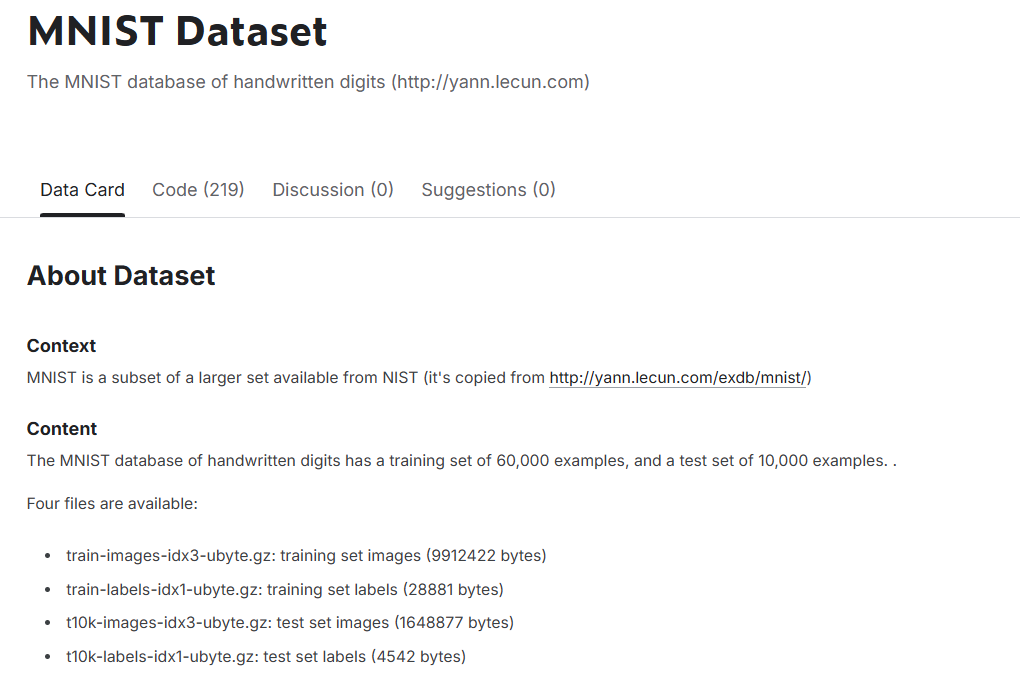